# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [26]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

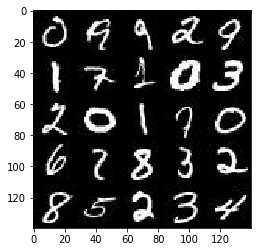

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

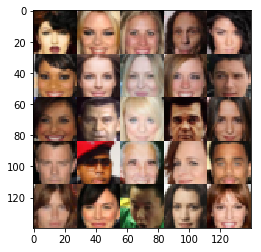

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [30]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(),name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
  
        x = tf.layers.conv2d(images, 64, 5, strides=2,padding='same')
        x = tf.maximum(alpha * x, x)
      
        x = tf.layers.conv2d(x, 128, 5, strides=2,padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
    
        x = tf.layers.conv2d(x, 256, 5, strides=2,padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
     
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=(not is_train)):
      
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
 
    
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2,padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
    
    
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

   
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake


    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(batch_size):
                steps += 1

                x = x * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    if steps % show_every == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 10.9957
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 7.9363
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 5.3219
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 3.6017
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 4.5885
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 2.1285
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 3.0597
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 2.1329
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.7887


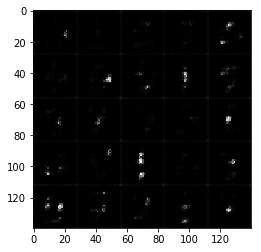

Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 2.8146
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 2.0562
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.7510
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 2.3802
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.5424
Epoch 1/2... Discriminator Loss: 1.8005... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.2501


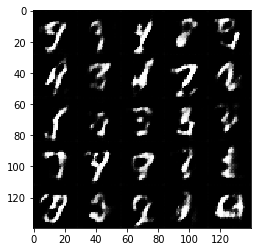

Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 1.6157
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.3937
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 2.0882
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 1.5695
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 2.1063
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.3309
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.8102


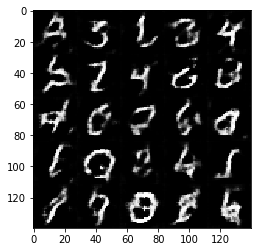

Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.4725
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.4485
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 1.9475
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 2.3481
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.5533


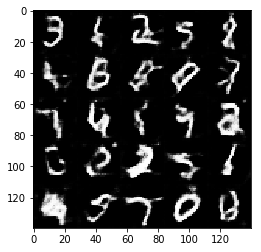

Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 1.6258
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 2.0287
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 2.2454


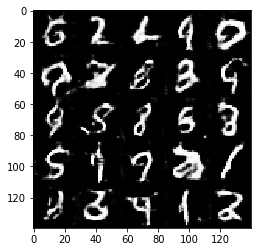

Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.4902
Epoch 2/2... Discriminator Loss: 1.7869... Generator Loss: 0.3453
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 1.4791
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.5308


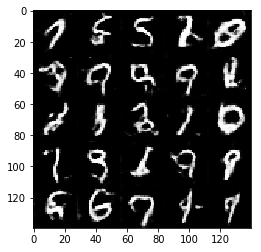

Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 1.4294
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.0757
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.6244
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.4867
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 1.5956
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.6512


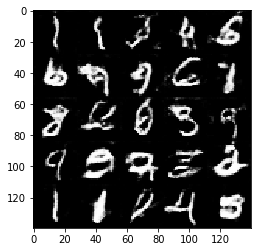

Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.2121
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 1.5612... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 1.1257
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 1.2256
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 1.9370
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.8088


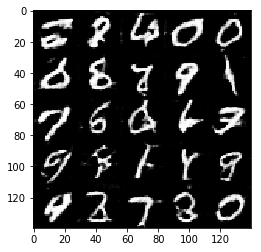

Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 2.0823
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 1.4873
Epoch 2/2... Discriminator Loss: 1.5136... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 1.3653
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.5996


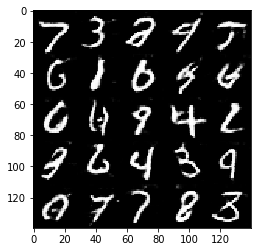

Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.9277


In [46]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 11.9206
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 5.4057
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 4.0321
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 2.6585
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 3.5813
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.4726
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 2.6042
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 2.4168... Generator Loss: 0.1952


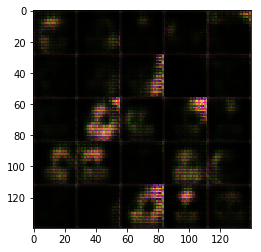

Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 1.8804... Generator Loss: 0.2972
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7845


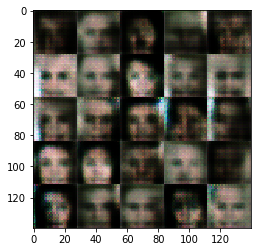

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.6997


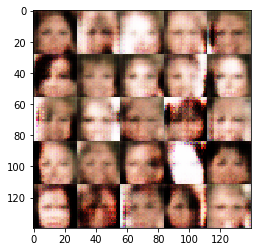

Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.3604


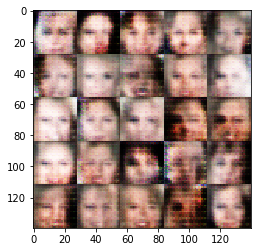

Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.6850... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.9646... Generator Loss: 0.4042


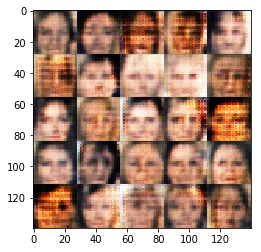

Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.6940


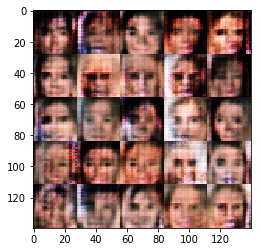

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.8650


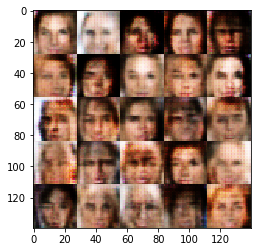

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.0585


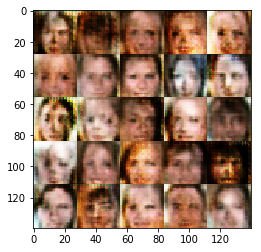

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.9340


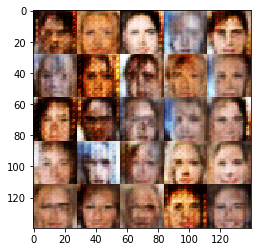

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.4151


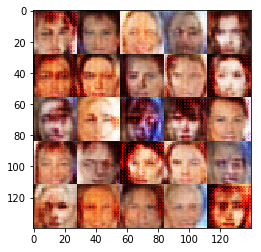

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 1.1987


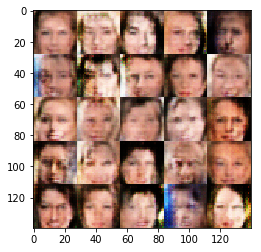

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.9114


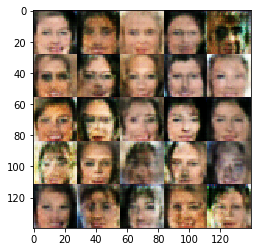

Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9303


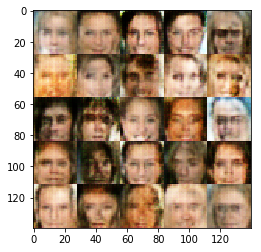

Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 1.0736


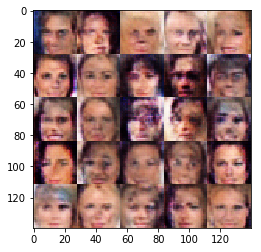

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.9428


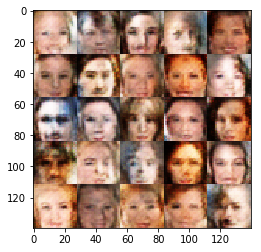

Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6364


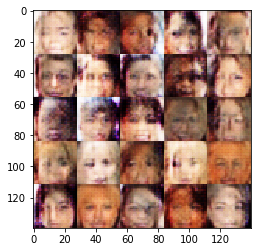

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8706


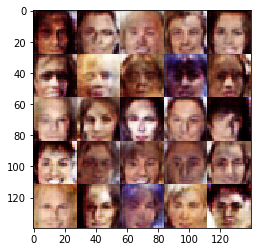

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.1934


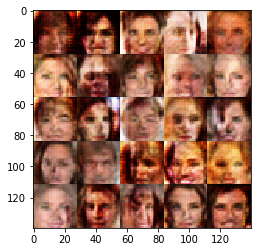

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 1.3323


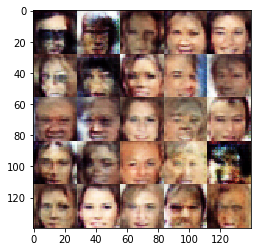

Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 2.0999
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.9069


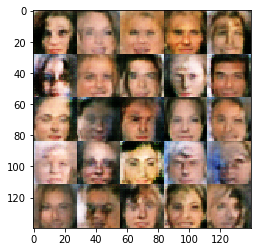

Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6360


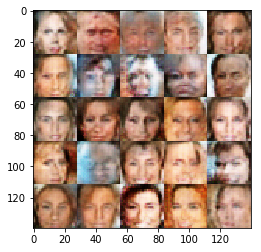

Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.2566


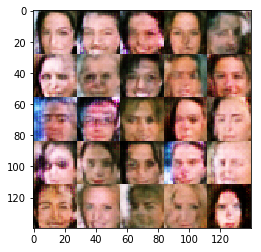

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7625


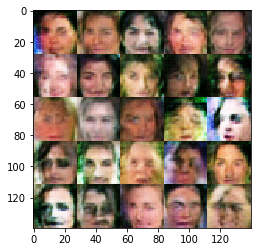

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0987


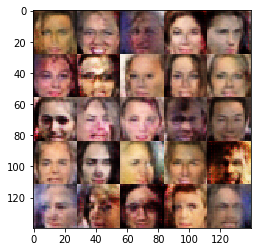

Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0487


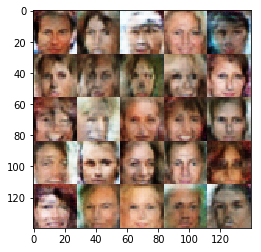

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8202


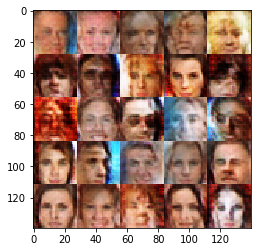

Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6857


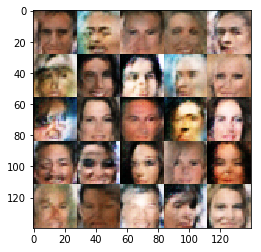

Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8042


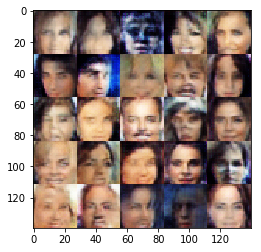

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8477


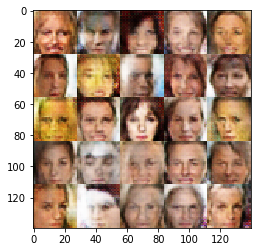

Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.9907


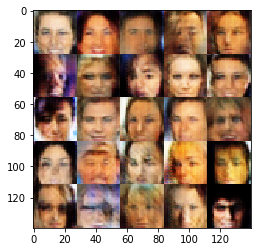

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8178


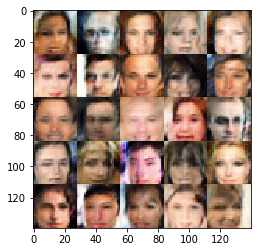

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.9591


In [47]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.